<a href="https://colab.research.google.com/github/duypham01/PDE_Poisson/blob/master/PDE_Poisson(pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.autograd import grad
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
import time


In [ ]:
class PDENetLight(nn.Module):

    # đọc paper để biết thêm chi tiết về tham số :))))
    # hidden_sz = M trong paper
    def __init__(self, dim_in, hidden_sz):
        super().__init__()
        self.hidden_sz = hidden_sz
        self.W1 = nn.Parameter(torch.Tensor(hidden_sz, dim_in))
        self.b1 = nn.Parameter(torch.Tensor(hidden_sz, 1))

        # 1st layer
        self.Uz1 = torch.nn.Parameter(torch.Tensor(hidden_sz, dim_in))
        self.Wz1 = torch.nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.bz1 = torch.nn.Parameter(torch.Tensor(hidden_sz, 1))

        self.Ug1 = torch.nn.Parameter(torch.Tensor(hidden_sz, dim_in))
        self.Wg1 = torch.nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.bg1 = torch.nn.Parameter(torch.Tensor(hidden_sz, 1))

        self.Ur1 = torch.nn.Parameter(torch.Tensor(hidden_sz, dim_in))
        self.Wr1 = torch.nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.br1 = torch.nn.Parameter(torch.Tensor(hidden_sz, 1))

        self.Uh1 = torch.nn.Parameter(torch.Tensor(hidden_sz, dim_in))
        self.Wh1 = torch.nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.bh1 = torch.nn.Parameter(torch.Tensor(hidden_sz, 1))

        # 2nd layer

        self.Uz2 = torch.nn.Parameter(torch.Tensor(hidden_sz, dim_in))
        self.Wz2 = torch.nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.bz2 = torch.nn.Parameter(torch.Tensor(hidden_sz, 1))

        self.Ug2 = torch.nn.Parameter(torch.Tensor(hidden_sz, dim_in))
        self.Wg2 = torch.nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.bg2 = torch.nn.Parameter(torch.Tensor(hidden_sz, 1))

        self.Ur2 = torch.nn.Parameter(torch.Tensor(hidden_sz, dim_in))
        self.Wr2 = torch.nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.br2 = torch.nn.Parameter(torch.Tensor(hidden_sz, 1))

        self.Uh2 = torch.nn.Parameter(torch.Tensor(hidden_sz, dim_in))
        self.Wh2 = torch.nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.bh2 = torch.nn.Parameter(torch.Tensor(hidden_sz, 1))

        # 3rd layer


        # output layer
        self.W = torch.nn.Parameter(torch.Tensor(1, hidden_sz))
        self.b = torch.nn.Parameter(torch.Tensor(1, 1))

    def init_weights(self):
        for p in self.parameters():
            nn.init.xavier_uniform_(p.data)

    def forward(self, x):
        Ones = torch.ones(self.hidden_sz, 1)

        S1 = torch.tanh(torch.mm(self.W1, x) + self.b1)

        # 1st layer
        Z1 = torch.tanh(torch.mm(self.Uz1, x) + torch.mm(self.Wz1, S1) + self.bz1)
        G1 = torch.tanh(torch.mm(self.Ug1, x) + torch.mm(self.Wg1, S1) + self.bg1)
        R1 = torch.tanh(torch.mm(self.Ur1, x) + torch.mm(self.Wr1, S1) + self.br1)
        # * is element - wise multiplication
        H1 = torch.tanh(torch.mm(self.Uh1, x) + torch.mm(self.Wh1, S1 * R1) + self.bh1)

        S2 = (Ones - G1) * H1 + Z1 * S1

        # 2nd layer
        Z2 = torch.tanh(torch.mm(self.Uz2, x) + torch.mm(self.Wz2, S2) + self.bz2)
        G2 = torch.tanh(torch.mm(self.Ug2, x) + torch.mm(self.Wg2, S2) + self.bg2)
        R2 = torch.tanh(torch.mm(self.Ur2, x) + torch.mm(self.Wr2, S2) + self.br2)
        H2 = torch.tanh(torch.mm(self.Uh2, x) + torch.mm(self.Wh2, S2 * R2) + self.bh2)

        S3 = (Ones - G2) * H2 + Z2 * S2


        # output layer
        out = torch.mm(self.W, S3) + self.b

        return out

    def save(self, file):
        torch.save(self, file)


def count_parameters(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name, ':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name, ':', num_param)
            total_param += num_param
    return total_param



In [ ]:
def laplacian(f, input_vector):
    gradient = grad(f, input_vector, create_graph=True)[0]
    ux = gradient.take(torch.tensor([0]))
    uxx = grad(ux, input_vector, create_graph=True)[0].take(torch.tensor([0]))
    uy = gradient.take(torch.tensor([1]))
    uyy = grad(uy, input_vector, create_graph=True)[0].take(torch.tensor([1]))
    return uxx + uyy


def boundary_condition(input):
    return input.take(torch.tensor([1])) + input.take(torch.tensor([1]))**2


# -laplace(u) = f
def right_hand_side(input):
    return 0


def exact_solution(spatial_time_point):
    return 3 + spatial_time_point.take(torch.tensor([1])) +0.5*(spatial_time_point.take(torch.tensor([1]))**2 - spatial_time_point.take(torch.tensor([0]))**2)


def exact_solution_scalar_value(x, y):
    return 3 + y + 0.5*(y**2 - x**2)


def random_data_points(batch_size):
    Omegapoints = []
    boundary_points = []

    radius = math.sqrt(6)
    for i in range(batch_size):
        phi = 2 * math.pi * random.random()
        r = radius * random.random()
        Omegapoints.append([r*math.cos(phi), r*math.sin(phi)])

    for i in range(batch_size):
        phi = 2 * math.pi * random.random()
        boundary_points.append([radius * math.cos(phi), radius * math.sin(phi)])
    return Omegapoints, boundary_points


def batch_loss(net, datapoints):
    G1 = G2 = 0
    Omegapoints, boundary_points = datapoints
    for Omegapoint in Omegapoints:
        Omegapoint_input = Variable(torch.Tensor(Omegapoint).resize_(2, 1), requires_grad=True)
        Omegapoint_output = net(Omegapoint_input)
        G1 += (- laplacian(Omegapoint_output, Omegapoint_input) - right_hand_side(Omegapoint_input)) ** 2

    for boundary_point in boundary_points:
        boundary_point_input = Variable(torch.Tensor(boundary_point).resize_(2, 1), requires_grad=True)
        boundary_point_output = net(boundary_point_input)
        G2 += (boundary_point_output - boundary_condition(boundary_point_input))**2

    G1 = G1 / len(Omegapoints)
    G2 = G2 / len(boundary_points)
    return G1 + G2


def plot_estimation_and_exact_solution(file_name):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 3, 0.05)
    X, Y = np.meshgrid(x, y)
    condition = X ** 2 + Y ** 2 <= 6
    zs = np.array([net(torch.tensor([x, y]).resize_(2,1)).item() for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    zs = np.array([exact_solution_scalar_value(x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z1 = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, color='red')
    ax.plot_surface(X, Y, Z1, color='blue')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # plt.show()
    plt.savefig(file_name)
    plt.close("all")


def random_points_in_circle():
    points = []
    radius = math.sqrt(6)
    for i in range(2000):
        phi = 2 * math.pi * random.random()
        r = radius * random.random()
        points.append([r*math.cos(phi), r*math.sin(phi)])
    return points

Iteration number: 1
Batch loss: tensor([[23.6359329224]], grad_fn=<AddBackward0>)
This iteration took 12.556180238723755 seconds
Total training time elapsed 0.2093027393023173 minutes
L2error = tensor([[115.8604049683]], grad_fn=<DivBackward0>)
Finished iteration number 1, saving model
Iteration number: 2
Batch loss: tensor([[21.8026390076]], grad_fn=<AddBackward0>)
This iteration took 11.647074699401855 seconds
Total training time elapsed 0.4206802447636922 minutes
L2error = tensor([[111.9764022827]], grad_fn=<DivBackward0>)
Finished iteration number 2, saving model
Iteration number: 3
Batch loss: tensor([[20.2805595398]], grad_fn=<AddBackward0>)
This iteration took 11.675792217254639 seconds
Total training time elapsed 0.6323347051938375 minutes
L2error = tensor([[119.1888122559]], grad_fn=<DivBackward0>)
Finished iteration number 3, saving model
Iteration number: 4
Batch loss: tensor([[19.4270267487]], grad_fn=<AddBackward0>)
This iteration took 12.121941804885864 seconds
Total trai

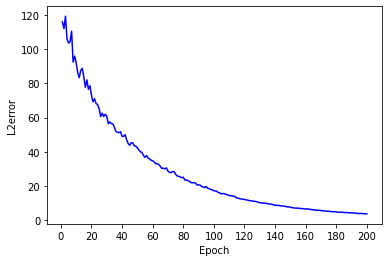

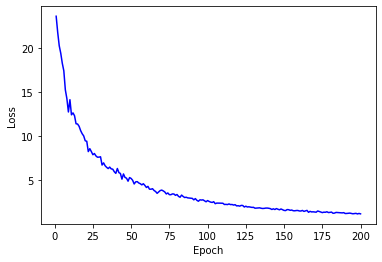

In [ ]:
net = PDENetLight(2, 10)
net.init_weights()

# plot_estimation_and_exact_solution('./result/testnoBatch/Initial.png')
l2_errors = []
losses = []

# net = torch.load('./model3')
torch.set_printoptions(precision=10)
learning_rate = 0.001
iterations_count = 0
start_training = time.time()
for i in range(200):
    print('Iteration number: ' + str(i + 1))
    sample = random_data_points(1000)  # sample space time point
    start_ite = time.time()
    # for j in range(4):
    #     # print('Batch iteration number: ' + str(j + 1))
    #     net.zero_grad()
    #     square_error = batch_loss(net, sample)  # calculate square error loss
    #     square_error.backward()  # calculate gradient of square loss w.r.t the parameters
    #     print('Batch loss: ' + str(square_error))
    #     for param in net.parameters():
    #         param.data -= learning_rate*param.grad.data
    #     if j == 0:
    #         losses.append(square_error.item())
    net.zero_grad()
    square_error = batch_loss(net, sample)  # calculate square error loss
    square_error.backward()  # calculate gradient of square loss w.r.t the parameters
    print('Batch loss: ' + str(square_error))
    for param in net.parameters():
        param.data -= learning_rate * param.grad.data
    losses.append(square_error.item())
    end_ite = time.time()
    ite_time = end_ite - start_ite
    total_time = end_ite - start_training
    print('This iteration took ' + str(ite_time) + ' seconds')
    print('Total training time elapsed ' + str(total_time/60) + ' minutes')
    L2_error = 0
    for point in random_points_in_circle():
        point_input = torch.Tensor(point).resize_(2,1)
        L2_error += (net(point_input) - exact_solution(point_input))**2
    L2_error /= 121
    l2_errors.append(L2_error.item())

    print('L2error = ' + str(L2_error))
    # print('Loss function = ' + str(square_error))

    print('Finished iteration number ' + str(i + 1) + ', saving model')
    model_path = './result/testnoBatch/model' + str(i+1) + 'th_ite'
   # net.save(model_path)
    # fig_path = './result/testnoBatch/' + str(i+1) + 'th_ite.png'
    # plot_estimation_and_exact_solution(fig_path)

print('Plotting and saving convergence history')
epochs = [i + 1 for i in range(200)]
plt.xticks(np.arange(0, 201, 20))

plt.figure(0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, losses, color = 'blue')
# plt.savefig('./result/testnoBatch/loss.png')

# with open('./result/testnoBatch/batchloss.txt', 'w+') as f:
#     for loss in losses:
#         f.write(str(loss) + '\n')

plt.figure(1)
plt.xlabel('Epoch')
plt.ylabel('L2error')

plt.plot(epochs, l2_errors, color = 'blue')
# plt.savefig('./result/testnoBatch/l2error.png')
# with open('./result/testnoBatch/L2error.txt', 'w+') as f:
#     for l2_error in l2_errors:
#         f.write(str(l2_error) + '\n')
